In [92]:
import numpy as np
import pandas as pd

import spacy
from spacy.util import minibatch,compounding

from tqdm import tqdm

import os

import random

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# Text Extraction from tweets that best represents sentiment from a text
# Predict Selected_text
# Implemented using Named Entity Recognition

In [15]:
train = pd.read_csv('data/train.csv')
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [16]:
test = pd.read_csv('data/test.csv')
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [17]:
train.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,40c848cee2,How is it that my preschoolers can bowl over a...,good,neutral
freq,1,1,199,11118


In [18]:
train.dropna(inplace=True)

In [19]:
pos_df = train[train['sentiment']=="positive"]
neg_df = train[train['sentiment']=="negative"]

In [20]:
# Transforming data to train spacy model
# TRAIN_DATA = [
#         ("Uber blew through $1 million a week", {"entities": [(0, 4, "ORG")]}),
#         ("Google rebrands its business apps", {"entities": [(0, 6, "ORG")]})]
# Array of tuples

def getTrainingDataForSpacy(df):
    train_data= []
    for row in df.itertuples():
        sub_text = row.selected_text
        text = row.text
        start = text.find(sub_text)
        end = start + len(sub_text) -1
        elt= (text, {'entities':[(start, end, "selected_text")]})
        train_data.append(elt)
    return train_data

In [38]:
def train(train_data, iterations, model_folder,model_name):
    # Create blank english language model
    model_exist = False
    if os.path.exists(model_folder):
        model_exist = True
        nlp = spacy.load(model_folder)  # load existing spaCy model
        print("Loaded model '%s'" % model_name)
    else:
        nlp = spacy.blank('en')
        print("Create blank en model")
    
    # If a blank model is being used, we have to add the entity recognizer to the pipeline. 
    # If an existing model is being used, we have to disable all other pipeline 
    # components during training using nlp.disable_pipes. 
    # This way, only the entity recognizer gets trained.
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
    else:
        ner = nlp.get_pipe('ner')
    
    # Add new entity labels to entity recognizer
    ner.add_label('selected_text')
    
    # Get names of other pipes to disable them during training 
    # So only NER is trained and update the weights
    
    # get names of other pipes to disable them during training
    pipe_exceptions = ["ner"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
    
    with nlp.disable_pipes(*other_pipes): # Only enable NER
        if(model_exist == True):
            nlp.resume_training()
        else:
            nlp.begin_training()
        for itn in range(iterations):
            random.shuffle(train_data)
            losses = {}
            # batch up the examples using spaCy's minibatch
            batches = minibatch(train_data, size=compounding(100.0, 1000.0, 1.1))
            for batch in batches:
                texts, annotations = zip(*batch)
                # Updating the weights
                nlp.update(
                    texts,  # batch of texts
                    annotations,  # batch of annotations
                    drop=0.5,  # dropout - make it harder to memorise data
                    losses=losses,
                )
            print("Losses", losses)
            
        #Save the trained model using nlp.to_disk.
        if model_folder is not None:        
            if not os.path.exists(model_folder):
                os.makedirs(model_folder)
            nlp.meta["name"] = model_name
            nlp.to_disk(model_folder)
            print("Saved model to", model_folder)
        return nlp

In [122]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [23]:
def predictSelectedText(row, model):
    text = row['text']
    selected_text = row['selected_text']
    doc = model(text)
    prediction = text
    for ent in doc.ents:
        prediction = ent.text
    jacc_score = jaccard(prediction, selected_text)
    return (prediction, jacc_score)

In [24]:
def trainModel(df, model_dir="", model_name="", iterations=0):
    X = df[['selected_text','text']]
    y = df['selected_text']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    train_data = getTrainingDataForSpacy(X_train)
    train(train_data, iterations, model_dir,model_name);
    model = spacy.load(model_dir)
    (prediction_test, jcc_test)=zip(*X_test.apply(predictSelectedText,model=model, axis=1))
    print('Avg jcc_test', sum(jcc_test)/len(jcc_test))
    (prediction_train, jcc_train)=zip(*X_train.apply(predictSelectedText,model=model, axis=1))
    print('Avg jcc_train', sum(jcc_train)/len(jcc_train))

In [121]:
def trainIterationModel(df, model_dir="", model_name="", iterations=0):
    X = df[['selected_text','text']]
    y = df['selected_text']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    train_data = getTrainingDataForSpacy(X_train)
    models=[]
    for i in range(iterations//10):
        print('model_'+str((i+1)*10))
        model = train(train_data, 10, model_dir,model_name);
        (prediction_test, jcc_test)=zip(*X_test.apply(predictSelectedText,model=model, axis=1))
        jcc_test_avg = sum(jcc_test)/len(jcc_test)
        print('Avg jcc_test', jcc_test_avg)      
        (prediction_train, jcc_train)=zip(*X_train.apply(predictSelectedText,model=model, axis=1))
        jcc_train_avg = sum(jcc_train)/len(jcc_train)
        print('Avg jcc_train', jcc_train_avg)
        model_meta ={'itr': (i+1)*10, 'model' : model, 'jcc_test':jcc_test_avg,'jcc_train_avg':jcc_train_avg}
        models.append(model_meta)
    return models

In [ ]:
pos_models = trainIterationModel(pos_df, model_dir="model/pos", model_name="model_pos", iterations=200)

In [ ]:
neg_models = trainIterationModel(neg_df, model_dir="model/neg", model_name="model_neg", iterations=200)

In [ ]:
pos_models_df = pd.DataFrame(pos_models)

In [112]:
pos_models_df.head(20)

,itr,jcc_test,jcc_train_avg,model
0,10,0.401230,0.429354,<spacy.lang.en.English object at 0x12f63fda0>
1,11,0.402526,0.447867,<spacy.lang.en.English object at 0x12f48bac8>
2,12,0.428135,0.490488,<spacy.lang.en.English object at 0x127539ac8>
3,13,0.436582,0.509416,<spacy.lang.en.English object at 0x125c7c2b0>
4,14,0.389338,0.466664,<spacy.lang.en.English object at 0x12a4c3d30>
5,15,0.445063,0.548952,<spacy.lang.en.English object at 0x12d1f3550>
6,16,0.427422,0.547646,<spacy.lang.en.English object at 0x125c7ccc0>
7,17,0.421948,0.561071,<spacy.lang.en.English object at 0x15e9fb9b0>
8,18,0.423198,0.566502,<spacy.lang.en.English object at 0x167a95d68>
9,19,0.423898,0.569876,<spacy.lang.en.English object at 0x16553b470>


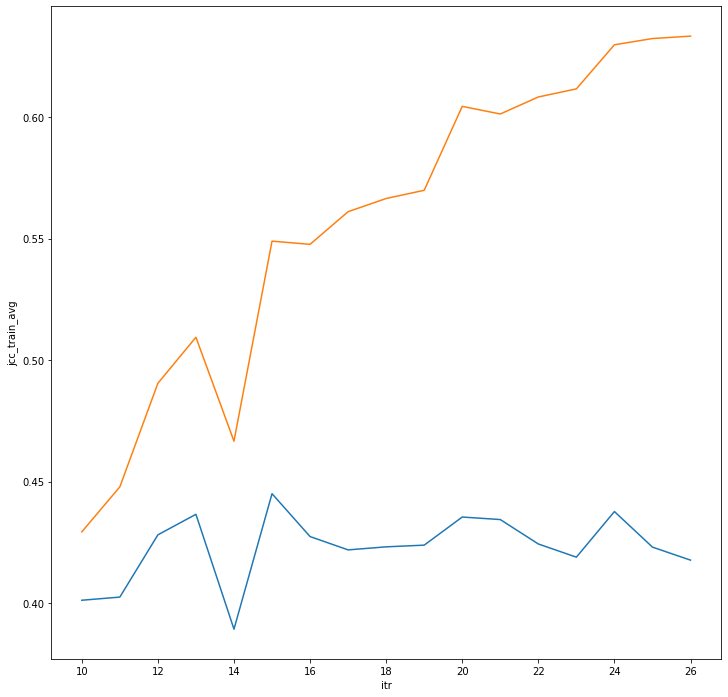

In [113]:
plt.figure(figsize=(12,12))
sns.lineplot('itr','jcc_test', data =pos_models_df )
sns.lineplot('itr','jcc_train_avg', data =pos_models_df )

In [ ]:
# Save positive model
positive_model = [d for d in pos_models if d['itr']==150][0]['model']
positive_model.to_disk('positive_model')

In [117]:
neg_models_df = pd.DataFrame(neg_models)

In [118]:
neg_models_df

,itr,jcc_test,jcc_train_avg,model
0,10,0.426069,0.421828,<spacy.lang.en.English object at 0x13afb1940>
1,11,0.440655,0.466502,<spacy.lang.en.English object at 0x1349957f0>
2,12,0.435930,0.481775,<spacy.lang.en.English object at 0x13929c6a0>
3,13,0.437618,0.486739,<spacy.lang.en.English object at 0x1398524a8>
4,14,0.425857,0.505174,<spacy.lang.en.English object at 0x1424ec8d0>
5,15,0.434058,0.523348,<spacy.lang.en.English object at 0x1483aba58>
6,16,0.431758,0.548384,<spacy.lang.en.English object at 0x147a36f98>
7,17,0.440234,0.560237,<spacy.lang.en.English object at 0x1528e8f98>
8,18,0.435739,0.564500,<spacy.lang.en.English object at 0x15288d6a0>
9,19,0.438667,0.585171,<spacy.lang.en.English object at 0x1520faef0>


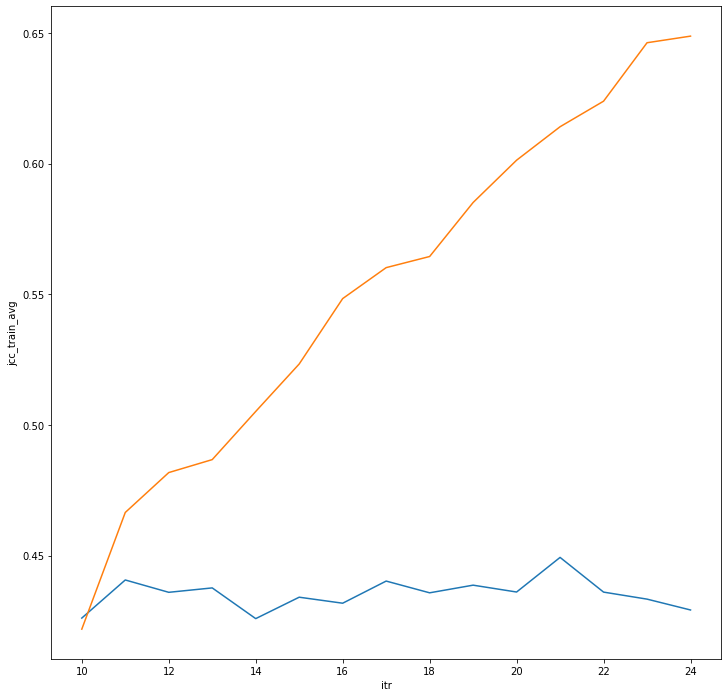

In [108]:
plt.figure(figsize=(12,12))
sns.lineplot('itr','jcc_test', data =neg_models_df )
sns.lineplot('itr','jcc_train_avg', data =neg_models_df )

In [109]:
# Save negative model
negative_model = [d for d in neg_models if d['itr']==210][0]['model']
negative_model.to_disk('negative_model')